# Stock Price Forecasting:  Apple

In this project we use two time series analysis  methods to forecast Apple Stock. Time refers to the analysis of change in the trend of the data over a period of time,  in this case we use two methods the LSTM recurrent neural network and Facebooks Prophet algorithm to forecast Apple Stock. 

We then compare which method produces better results, LSTM or Prophet?

We use the data from 2017-2020 for training anf the 2021 data for forecasting!

In [1]:

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from fbprophet import Prophet

In [4]:
# #import external pandas_datareader library with alias of web
# import pandas_datareader as web
# import datetime
 
# #Start and end date to download Apple stock!
# start = datetime.datetime(2016, 12, 31)
# end = datetime.datetime(2021, 2, 8)
 
# #DataReader method name is case sensitive
# df = web.DataReader("aapl", 'yahoo', start, end)
#  modelPro=Prophet(yearly_seasonality=False,
#               weekly_seasonality=False,
#               daily_seasonality=False).add_seasonality(name="daily",
#                                                              period=10,
#                                                              fourier_order=100)
# #Save the dataframe as csv    
# df.to_csv('AppleStock2017Feb082021.csv')

In [5]:
#Read all Apple stock data
appleData=pd.read_csv('AppleStock2017Feb082021.csv')

In [6]:
appleData.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0,27.459938
1,2017-01-04,29.127501,28.937500,28.962500,29.004999,84472400.0,27.429203
2,2017-01-05,29.215000,28.952499,28.980000,29.152500,88774400.0,27.568691
3,2017-01-06,29.540001,29.117500,29.195000,29.477501,127007600.0,27.876030
4,2017-01-09,29.857500,29.485001,29.487499,29.747499,134247600.0,28.131361


In [7]:
appleData.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1027,2021-02-02,136.309998,134.610001,135.729996,134.990005,83305400.0,134.788589
1028,2021-02-03,135.770004,133.610001,135.759995,133.940002,89880900.0,133.740158
1029,2021-02-04,137.399994,134.589996,136.300003,137.389999,84183100.0,137.184998
1030,2021-02-05,137.419998,135.860001,137.350006,136.759995,75524000.0,136.759995
1031,2021-02-08,136.960007,134.919998,136.029999,136.910004,71297200.0,136.910004


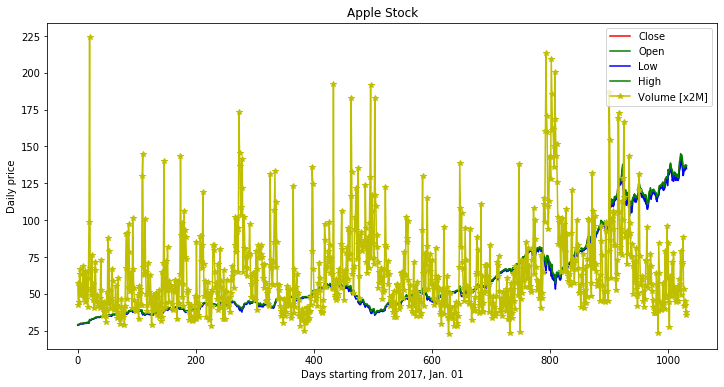

In [8]:
plt.figure(figsize=(12,6))
plt.plot(appleData['Close'],'r', label='Close')
plt.plot(appleData['Open'],'g',label='Open')
plt.plot(appleData['Low'],'b',label='Low')
plt.plot(appleData['High'],'g',label='High')
plt.plot(appleData['Volume']/2000000, '*-y', label='Volume [x2M]')
plt.ylabel('Daily price')
plt.xlabel('Days starting from 2017, Jan. 01')
plt.legend()
plt.title('Apple Stock')
plt.show()

It looks like high volumes are roughly associated with Close price. Can the Volume be a good predictor?!!

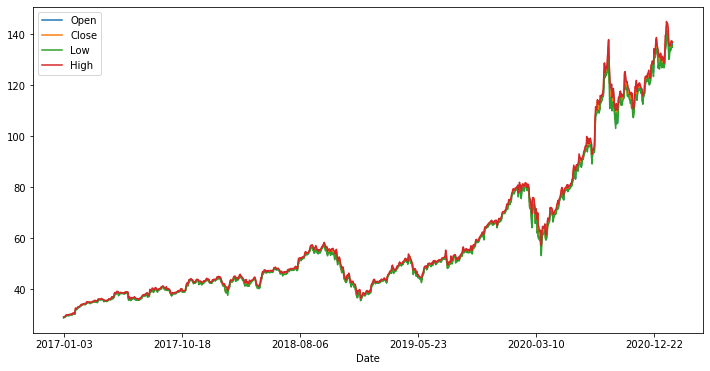

In [9]:
appleData.plot('Date',['Open','Close','Low','High'], figsize=(12,6))

You can see in the above figure for the Close and Open that  the trend is highly non-linear and it is very difficult to capture the trend using this information. This is where the power of LSTM can be utilized.  Can the Prophet be useful? We will see!!!

# LSTM 

Let us know apply the LSTM method.

In [10]:
# Scale the Close value  from zerpo to 1
appleClose=appleData['Close'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range = (0, 1))

apple_Close_scaled = scaler.fit_transform(appleClose)

In [11]:
appleTest=appleData[appleData['Date']>='2020-01-01']
trainData=apple_Close_scaled[0:len(appleData)-len(appleTest)]
testData=apple_Close_scaled[len(appleData)-len(appleTest):]

print(f"Shape of training data is {trainData.shape} ")
print(f"Shape of testing  data is {testData.shape} ")

Shape of training data is (754, 1) 
Shape of testing  data is (278, 1) 


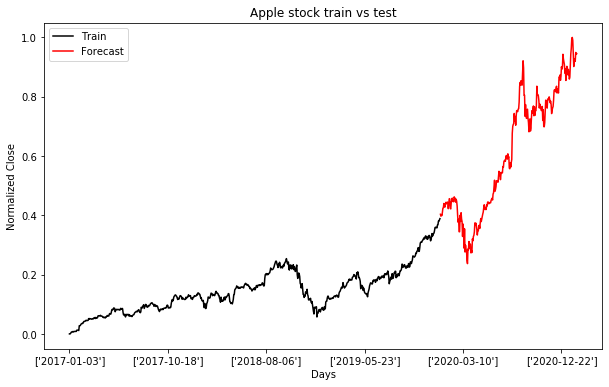

In [12]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(trainData)),trainData,'k',label='Train')
plt.plot(np.arange(len(trainData),len(trainData)+len(testData)),testData,'r',label='Forecast')
plt.title('Apple stock train vs test')
plt.ylabel('Normalized Close')
plt.xticks([0, 200, 400, 600, 800, 1000],(appleData[['Date']].iloc[[0, 200, 400, 600, 800, 1000],:].values))
plt.xlabel('Days')
plt.legend()

In [13]:
# Convert the training and testing to supervised 
def to_supervised(data, window):
    features_set = [] 
    labels = []
    for i in range(window, len(data)):
        features_set.append(data[i-window:i, 0])
        labels.append(data[i, 0])
    return np.array(features_set), np.array(labels).reshape(-1,1)

def to_reshape(dataX):
    data_xx=np.reshape(dataX,(dataX.shape[0],dataX.shape[1],1))
    print('The shape of of the data is: {}'.format(data_xx.shape))
    return data_xx


# LSTM model 

def LSTLModel():
    model=Sequential()
    model.add(LSTM(units=80, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=30, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return model

A preliminary investigation of the window range showed that a value bweetwen 60 and 70 produced resulted with the minimum RMSE of the apple stock. 
lesset window produced higher error because it doesn't provide for the LSTM sufficient information to forecast. Higher values also prouce lare RMS error persumably because it reduces the size of the test and training size. We selected window=60 in this experiment!

In [14]:
# Now let run the model 

x_train, y_train=to_supervised(trainData,60)
x_test,y_test=to_supervised(testData,60)

x_train=to_reshape(x_train)
x_test=to_reshape(x_test)

model=LSTLModel()
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200,batch_size=32,verbose=0)

The shape of of the data is: (694, 60, 1)
The shape of of the data is: (218, 60, 1)


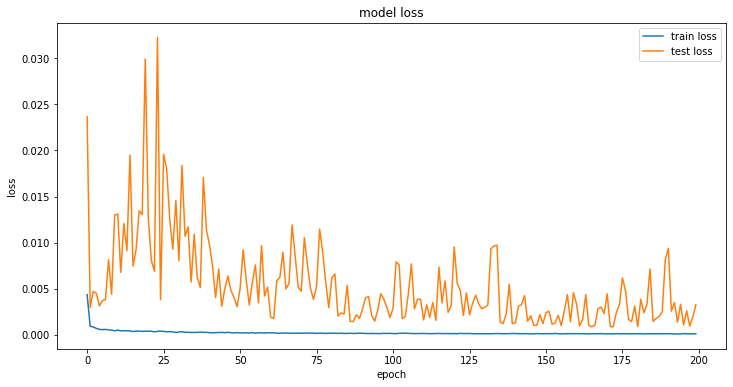

In [15]:
#plot histry
fig = plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')
plt.show()

# LSTM predictions

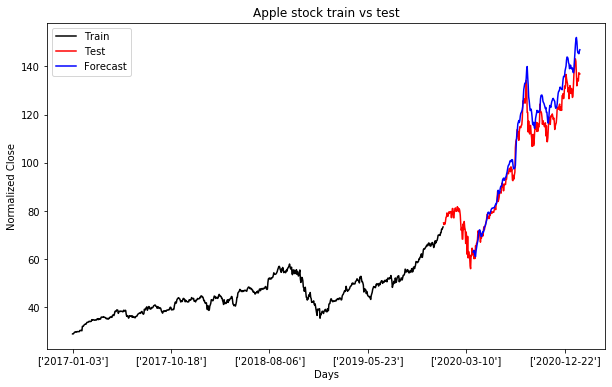

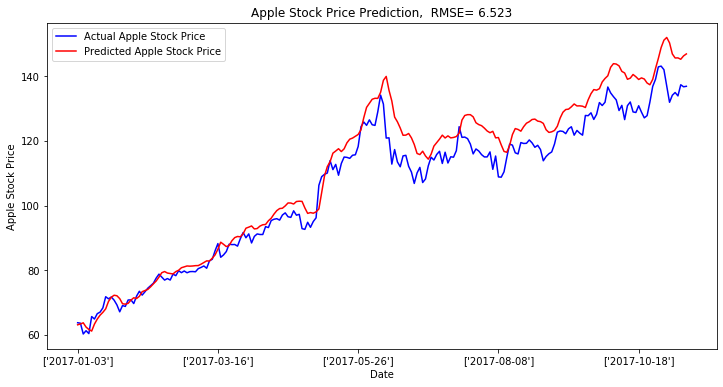

In [16]:
predictions = model.predict(x_test,batch_size=32)
predictions = scaler.inverse_transform(predictions)
actual=scaler.inverse_transform(y_test)

RMSE=np.sqrt(mean_squared_error(predictions,actual))

plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(trainData)),scaler.inverse_transform(trainData),'k',label='Train')
plt.plot(np.arange(len(trainData),len(trainData)+len(testData)),scaler.inverse_transform(testData),'r',label='Test')
plt.plot(np.arange(len(trainData)+60,len(trainData)+60+len(predictions)),predictions,'b',label='Forecast')
plt.title('Apple stock train vs test')
plt.ylabel('Normalized Close')
plt.xticks([0, 200, 400, 600, 800, 1000],(appleData[['Date']].iloc[[0, 200, 400, 600, 800, 1000],:].values))
plt.xlabel('Days')
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(actual, color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title(f'Apple Stock Price Prediction,  RMSE= {np.round(RMSE,3)}')
plt.xlabel('Date')
plt.xticks([0, 50, 100, 150, 200],(appleData[['Date']].iloc[[0, 50, 100, 150, 200],:].values))
plt.ylabel('Apple Stock Price')
plt.legend()
plt.savefig('LSTMAppleStock.png', facecolor='w', format='png')
plt.show()

# Facebook's Prophet for Apple Stock forecasting

In [17]:
#Prophet uses ds as the date name, and y, the variable we want to forecst
appleData.columns=['ds', 'High', 'Low', 'Open', 'y', 'Volume', 'Adj Close']

In [18]:
appleData.head()

,ds,High,Low,Open,y,Volume,Adj Close
0,2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0,27.459938
1,2017-01-04,29.127501,28.937500,28.962500,29.004999,84472400.0,27.429203
2,2017-01-05,29.215000,28.952499,28.980000,29.152500,88774400.0,27.568691
3,2017-01-06,29.540001,29.117500,29.195000,29.477501,127007600.0,27.876030
4,2017-01-09,29.857500,29.485001,29.487499,29.747499,134247600.0,28.131361


In [19]:
appleData.head()

,ds,High,Low,Open,y,Volume,Adj Close
0,2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0,27.459938
1,2017-01-04,29.127501,28.937500,28.962500,29.004999,84472400.0,27.429203
2,2017-01-05,29.215000,28.952499,28.980000,29.152500,88774400.0,27.568691
3,2017-01-06,29.540001,29.117500,29.195000,29.477501,127007600.0,27.876030
4,2017-01-09,29.857500,29.485001,29.487499,29.747499,134247600.0,28.131361


In [20]:
appleData.head()

,ds,High,Low,Open,y,Volume,Adj Close
0,2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0,27.459938
1,2017-01-04,29.127501,28.937500,28.962500,29.004999,84472400.0,27.429203
2,2017-01-05,29.215000,28.952499,28.980000,29.152500,88774400.0,27.568691
3,2017-01-06,29.540001,29.117500,29.195000,29.477501,127007600.0,27.876030
4,2017-01-09,29.857500,29.485001,29.487499,29.747499,134247600.0,28.131361


In [21]:
testDataP=appleData[appleData['ds']>='2020-01-01']
trainDataP=appleData[appleData['ds']<'2020-01-01']
print(f"Shape of training data for Prophet is {trainDataP.shape}")
print(f"Shape of testing  data  for Prophet is {testDataP.shape}")

Shape of training data for Prophet is (754, 7)
Shape of testing  data  for Prophet is (278, 7)


In [22]:
modelPro=Prophet(yearly_seasonality=False,
              weekly_seasonality=False,
              daily_seasonality=False).add_seasonality(name="daily",
                                                             period=10,
                                                             fourier_order=100)

In [23]:
modelPro.fit(trainDataP)

In [24]:
future=modelPro.make_future_dataframe(freq='D',periods=len(testDataP))

In [25]:
pred=modelPro.predict(future)

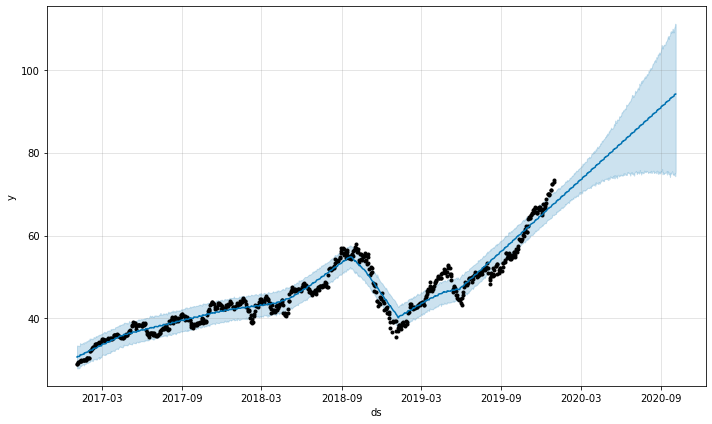

In [27]:
fig=modelPro.plot(pred)

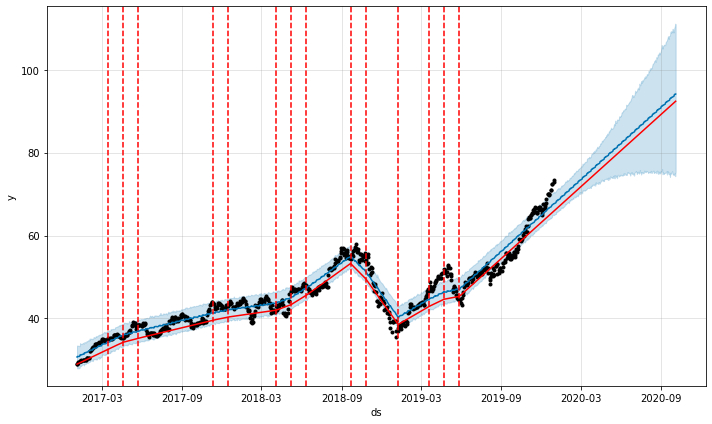

In [28]:
from fbprophet.plot import add_changepoints_to_plot
fig = modelPro.plot(pred)
a = add_changepoints_to_plot(fig.gca(), modelPro,pred)


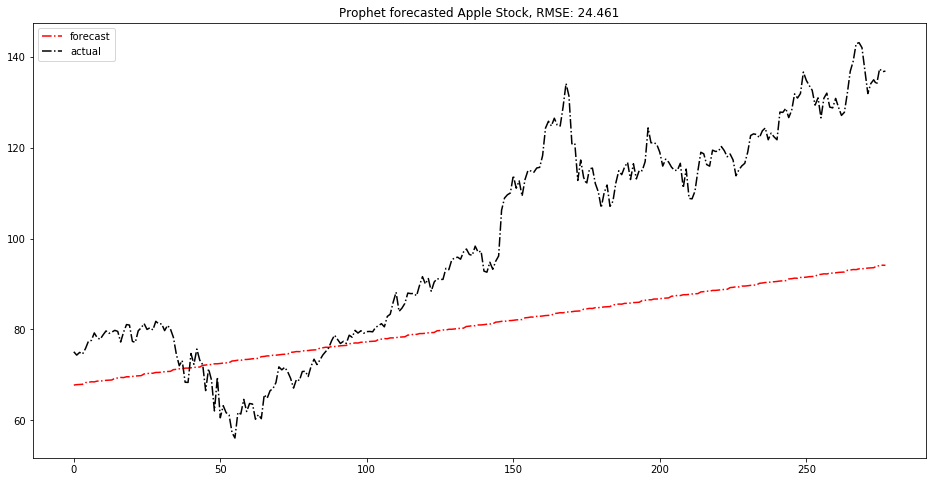

In [29]:
#plot the last 72 hour actual and forecast
RMSE=np.sqrt(mean_squared_error(pred['yhat'][754:].values,testDataP['y'].values))
plt.figure(figsize=(16,8))
plt.plot(pred['yhat'][754:].values,'-.r',label='forecast')
plt.plot(testDataP['y'].values,'-.k',label='actual')
plt.title('Prophet forecasted Apple Stock, RMSE: {}'.format(round(RMSE,3)))
plt.legend()
plt.rcParams.update({'font.size': 16,'lines.linewidth':1.5})
plt.savefig('ProphetAppleStock.png',format='png')